In [19]:
import duckdb
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path

# Set some styling things for visualization
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [13]:
def create_con():
    con = duckdb.connect(database=':memory:')
    return con

def execute_local(con, query):
    result = con.execute(query).fetchdf()
    return result

con = create_con()

ns = [100, 250, 500, 1000, 1500, 2000]

for n in ns:
    q = f'CREATE TABLE patients{n} AS SELECT * FROM read_csv_auto(\'Data/synthetic/csv/{n}/patients.csv\')'
    
    execute_local(con, q)

# We test on 500 syntetic patients, later, we will run everything on all file sizes
patients = execute_local(con, '''select * from patients500''')

In [3]:
def date_to_age(birthdates):
    today = date.today()
    return birthdates.apply(
                lambda x: x.apply(
                    lambda y: int(today.year - y.year - ((today.month, today.day) < (y.month, y.day)))))


def clean_input(patients):
    # Build the dataframe
    df = patients.copy()

    # Convert birthdate to age
    age_col = date_to_age(df[['BIRTHDATE']])
    df["AGE"] = age_col

    # drop irrelevant columns or columns that contain too sensitive information
    # Note that we leave first and last names in the dataset, this is so that we have a human readable way 
    # to differentiate between patients.
    df.drop(['LAT', 'LON', 'SSN', 'DRIVERS', 'PASSPORT', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY'], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df.columns

    # Rearange column order
    cols = ['Id', 'BIRTHDATE', 'AGE', 'DEATHDATE', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX',
             'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ZIP']

    df = df[cols]

    # We only want alive people (people withour a death date)
    df.drop(df[df['DEATHDATE']  == df['DEATHDATE']].index, inplace=True)
    df.drop(['DEATHDATE'], axis=1, inplace=True)

    return df

df = clean_input(patients)
df

,Id,BIRTHDATE,AGE,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ZIP
0,b8d8578a-3403-a5c5-6e44-19cae89e66e6,1996-09-18,25,Mr.,Josiah310,Marks830,NaN,NaN,NaN,white,nonhispanic,M,Lelystad Flevoland NL,8241
1,6f196958-2892-9208-d039-3bc0da53e441,1967-11-10,54,Mrs.,Chanel977,Corkery305,NaN,Erdman779,M,white,nonhispanic,F,Lelystad Flevoland NL,8303
2,16b4683a-7530-6f59-8b55-55c2ff94cb4a,1981-12-03,40,Mr.,Shelton25,Kirlin939,NaN,NaN,M,white,nonhispanic,M,Lelystad Flevoland NL,8321
3,30043951-c45e-bd62-73bf-33416a271dea,1997-07-16,24,Ms.,Marcia467,Ryan260,NaN,NaN,NaN,white,nonhispanic,F,Lelystad Flevoland NL,3897
4,03b2c661-cd30-40a7-2afd-d600d07533da,1966-01-09,56,Mr.,Michel472,Berge125,NaN,NaN,M,white,nonhispanic,M,Emmeloord Flevoland NL,8307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,122adea7-6afd-81cb-2162-185263fa7ce9,1956-03-21,66,Mr.,Antonia30,Breitenberg711,NaN,NaN,M,white,nonhispanic,M,Emmeloord Flevoland NL,8321
532,ba345a55-3a6d-8884-fa60-41d41375d2fb,1988-12-24,33,Ms.,Trina350,Schmeler639,NaN,NaN,S,white,nonhispanic,F,Lelystad Flevoland NL,8211
533,6cebf2c8-2017-4e8a-3bff-d15e62ba8a3b,1970-01-18,52,Mrs.,Leena55,Ebert178,NaN,Casper496,M,white,nonhispanic,F,Dronten Flevoland NL,8302
534,6e3e5e33-c0bd-6916-7b6f-d671e1296a3d,1979-01-24,43,Mrs.,Cleopatra935,Schmitt836,NaN,Schimmel440,M,white,nonhispanic,F,Emmeloord Flevoland NL,8302


In [4]:
def get_subquery(row, col):
    if type(row[col]) == str:
        return f'{col} == \'{row[col]}\''
    return f'{col} == {row[col]}'

def build_k_anonymity_query(row, columns):
    query = ' & '.join([get_subquery(row, col) for col in columns])
    return query

def k_anonymity_query(df, row):
    query = build_k_anonymity_query(row, df.columns)
    return df.query(query)

def make_k_anonymous(df, k):  
    tmp = df.copy()
    tmp = tmp.where(pd.notnull(tmp), 'unknown')
    for index, row in tmp.iterrows():
        rows = k_anonymity_query(tmp, row)
        if rows.shape[0] < k:
            tmp.drop(index,inplace=True)
    tmp.reset_index(drop=True, inplace=True)
    return tmp

def isKAnonymized(df, k):
    for index, row in df.iterrows():
        rows = k_anonymity_query(df, row)
        if rows.shape[0] < k:
            print(rows)
            return False
    return True

def generalize(df, depths):
    return df.apply(lambda x: x.apply(lambda y: int(int(y/(10**depths[x.name]))*(10**depths[x.name]))))


def getRowLoss(data, ks):
    losses = []
    for k in ks:
        anonimized = make_k_anonymous(data, k)
        losses.append(data.shape[0]- anonimized.shape[0])
    return losses


# old version of the query
# query = ' & '.join([f'{col} == \'{row[col]}\'' if type(row[col]) == str else f'{col} == {row[col]}'for col in df.columns])


In [9]:
depths = {
    'ZIP': 2,
    'AGE': 1
}

k = 5

generalized = generalize(df[['ZIP', 'AGE']], depths)

generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")

k_anonymous = make_k_anonymous(generalized, k)

# isKAnonymized(k_anonymous, k)

print(generalized.shape)
print(k_anonymous.shape)
print('Row loss: %d'%(generalized.shape[0]-k_anonymous.shape[0]))
# print(k_anonymous)
k_anonymous

(476, 4)
(396, 4)
Row loss: 80


,ZIP,AGE,GENDER,MARITAL
0,8200,20,M,unknown
1,8300,50,F,M
2,8300,40,M,M
3,8300,50,M,M
4,8200,30,F,M
...,...,...,...,...
391,8200,30,M,S
392,8300,60,M,M
393,8300,50,F,M
394,8300,40,F,M


In [6]:
ks = range(1, 25)

losses = getRowLoss(generalized, ks)

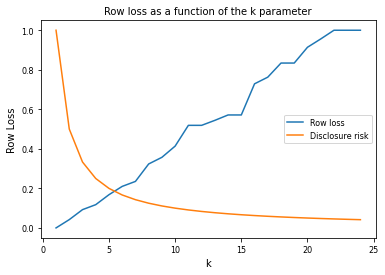

In [7]:
losses = np.array(losses)
plt.plot(ks, losses/len(generalized), label = "Row loss")
plt.plot(ks, np.ones(len(ks))/ks, label = "Disclosure risk")
plt.xlabel('k')
plt.ylabel('Row Loss')
plt.title('Row loss as a function of the k parameter')
plt.legend()
plt.show()

In [8]:
# my own sanity check, nevermind this part
unknowns =  k_anonymous.loc[k_anonymous['MARITAL'] ==  'unknown']
singles = k_anonymous.loc[k_anonymous['MARITAL'] ==  'S']
maried = k_anonymous.loc[k_anonymous['MARITAL'] ==  'M']

In [23]:
# Make all datasets anonymous for k={5, 10, 15, 20, 25}
ks = [5, 10, 15, 20, 25]

for n in ns:
    patients = execute_local(con, f'select * from patients{n}')
    df = clean_input(patients)
    
    generalized = generalize(df[['ZIP', 'AGE']], depths)
    generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
    generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")
    
    for k in ks:
        filepath = Path(f'Data/Anonymized/k{k}n{n}.csv') 
        k_anonymous = make_k_anonymous(generalized, k)
        k_anonymous.to_csv(filepath)

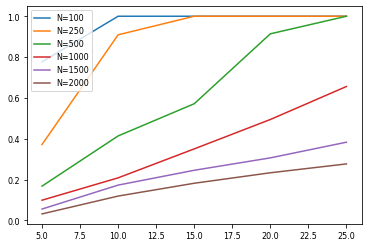

In [30]:
colors = ['red', 'green', 'blue', 'cyan', 'm','black']

for (n, color) in zip(ns, colors):
    patients = execute_local(con, f'select * from patients{n}')
    df = clean_input(patients)
    
    generalized = generalize(df[['ZIP', 'AGE']], depths)
    generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
    generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")
    losses = []
    for k in ks:
        anonimized = pd.read_csv(f'Data/Anonymized/k{k}n{n}.csv')
        losses.append(generalized.shape[0]- anonimized.shape[0])
    losses = np.array(losses)
    plt.plot(ks, losses/len(generalized), label=f'N={n}')
plt.legend()